**IoT Intrusion Detection Competition using Machine Learning**


Reworked from group project I worked on for my Applied Machine Learning class

In [51]:
# Read in the libraries used throughout the script
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
from pathlib import Path
import sys
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score,cross_val_predict,cross_validate,GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve, roc_auc_score,matthews_corrcoef, recall_score, precision_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from time import time
from sklearn.feature_selection import SelectKBest,chi2,f_classif, f_regression
from keras.models import Sequential 
from keras.layers import Dense, Dropout,Input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop
from keras.regularizers import l1
from keras import optimizers, Model
from operator import itemgetter
from matplotlib import pyplot as plt
import tensorflow as tf
from rbf_keras.rbflayer import RBFLayer
from rbf_keras.kmeans_initializer import InitCentersKMeans
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# parent directory
par_dir = str(Path.cwd().parent)

sys.path.insert(1, par_dir+'\\aml_proj_f\\help_functions')
import utils

print(tf.__version__)
np.random.seed(41)
tf.random.set_random_seed(41)

1.14.0


In [2]:
# load the train and test data sets
par_dir = str(Path.cwd().parent)
sys.path.insert(1, par_dir+'\\aml_proj_f\\help_functions')

df = pd.read_csv(par_dir+'/data/raw/train_imperson_without4n7_balanced_data.csv')
test_df = pd.read_csv(par_dir+'\\data\\raw\\test_imperson_without4n7_balanced_data.csv')


**PRE-PROCESSING**
<br><br>
Before starting to model the data, we need to understand it. To do so, we carried out a number of visualisation and preparation techniques.

1. Cleaning data: check for missing and remove constant values.
    
2. Visualisation: visually check the data and look for patterns/correlations.
    
3. Standardisation of data

A condensed version of this is shown below.

Step 1 - Cleaning data
<br>
We first look at basic stats of the data and check for missing values. Then we remove all variables that have a constant value across all observations and are left with 79 variables that are relevant for prediction. Finally, we look at the datatypes the data has and create lists that hold the names of the binary and the names of the continuous variables, as they will need to get preprocessed differently.

In [3]:
### Step 1 - Cleaning data
display(df.describe())

#Step 1.1 - Remove missing values
df.dropna()

# Step 1.2 - Remove constants
df = df.loc[:, df.nunique() != 1] 
print(df.shape)

# split data to target(Y) and features(X)
X = df.iloc[:, :-1] 
Y = df.iloc[:, -1] 

# Investigate data types
X_dtypes = X.dtypes
feature_list = X.columns
cts_feature_list = X.columns[X_dtypes=='float64']
bin_feature_list = X.columns[X_dtypes=='int64']
## We have 31 integer variables and 48 float variables

,1,2,3,5,6,8,9,10,11,12,...,146,147,148,149,150,151,152,153,154,155
count,97044.0,97044.0,97044.0,97044.000000,97044.000000,97044.000000,97044.000000,97044.0,97044.0,97044.0,...,97044.000000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000000,97044.000000
mean,0.0,0.0,0.0,0.006252,0.006252,0.193837,0.193837,0.0,0.0,0.0,...,0.028436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178474,0.500000
std,0.0,0.0,0.0,0.015541,0.015541,0.354444,0.354444,0.0,0.0,0.0,...,0.062765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360078,0.500003
min,0.0,0.0,0.0,0.000003,0.000003,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,0.0,0.0,0.0,0.001442,0.001442,0.037908,0.037908,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
50%,0.0,0.0,0.0,0.003706,0.003706,0.037908,0.037908,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023873,0.500000
75%,0.0,0.0,0.0,0.005916,0.005916,0.054902,0.054902,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023873,1.000000
max,0.0,0.0,0.0,0.978440,0.978440,1.000000,1.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000


(97044, 79)


Step 2 - Visualisation
<br>
We prefer histograms because density plots will take a lot of computation power for 79 variables. We see that most float variables are either values close to 0 or 1. Only 38, 61, 64, 67, 140 and 142 are slightly distributed (but not much). We then create box and whisker plots. Both plots show that the vast majority of the variables are not uniformly distributed.

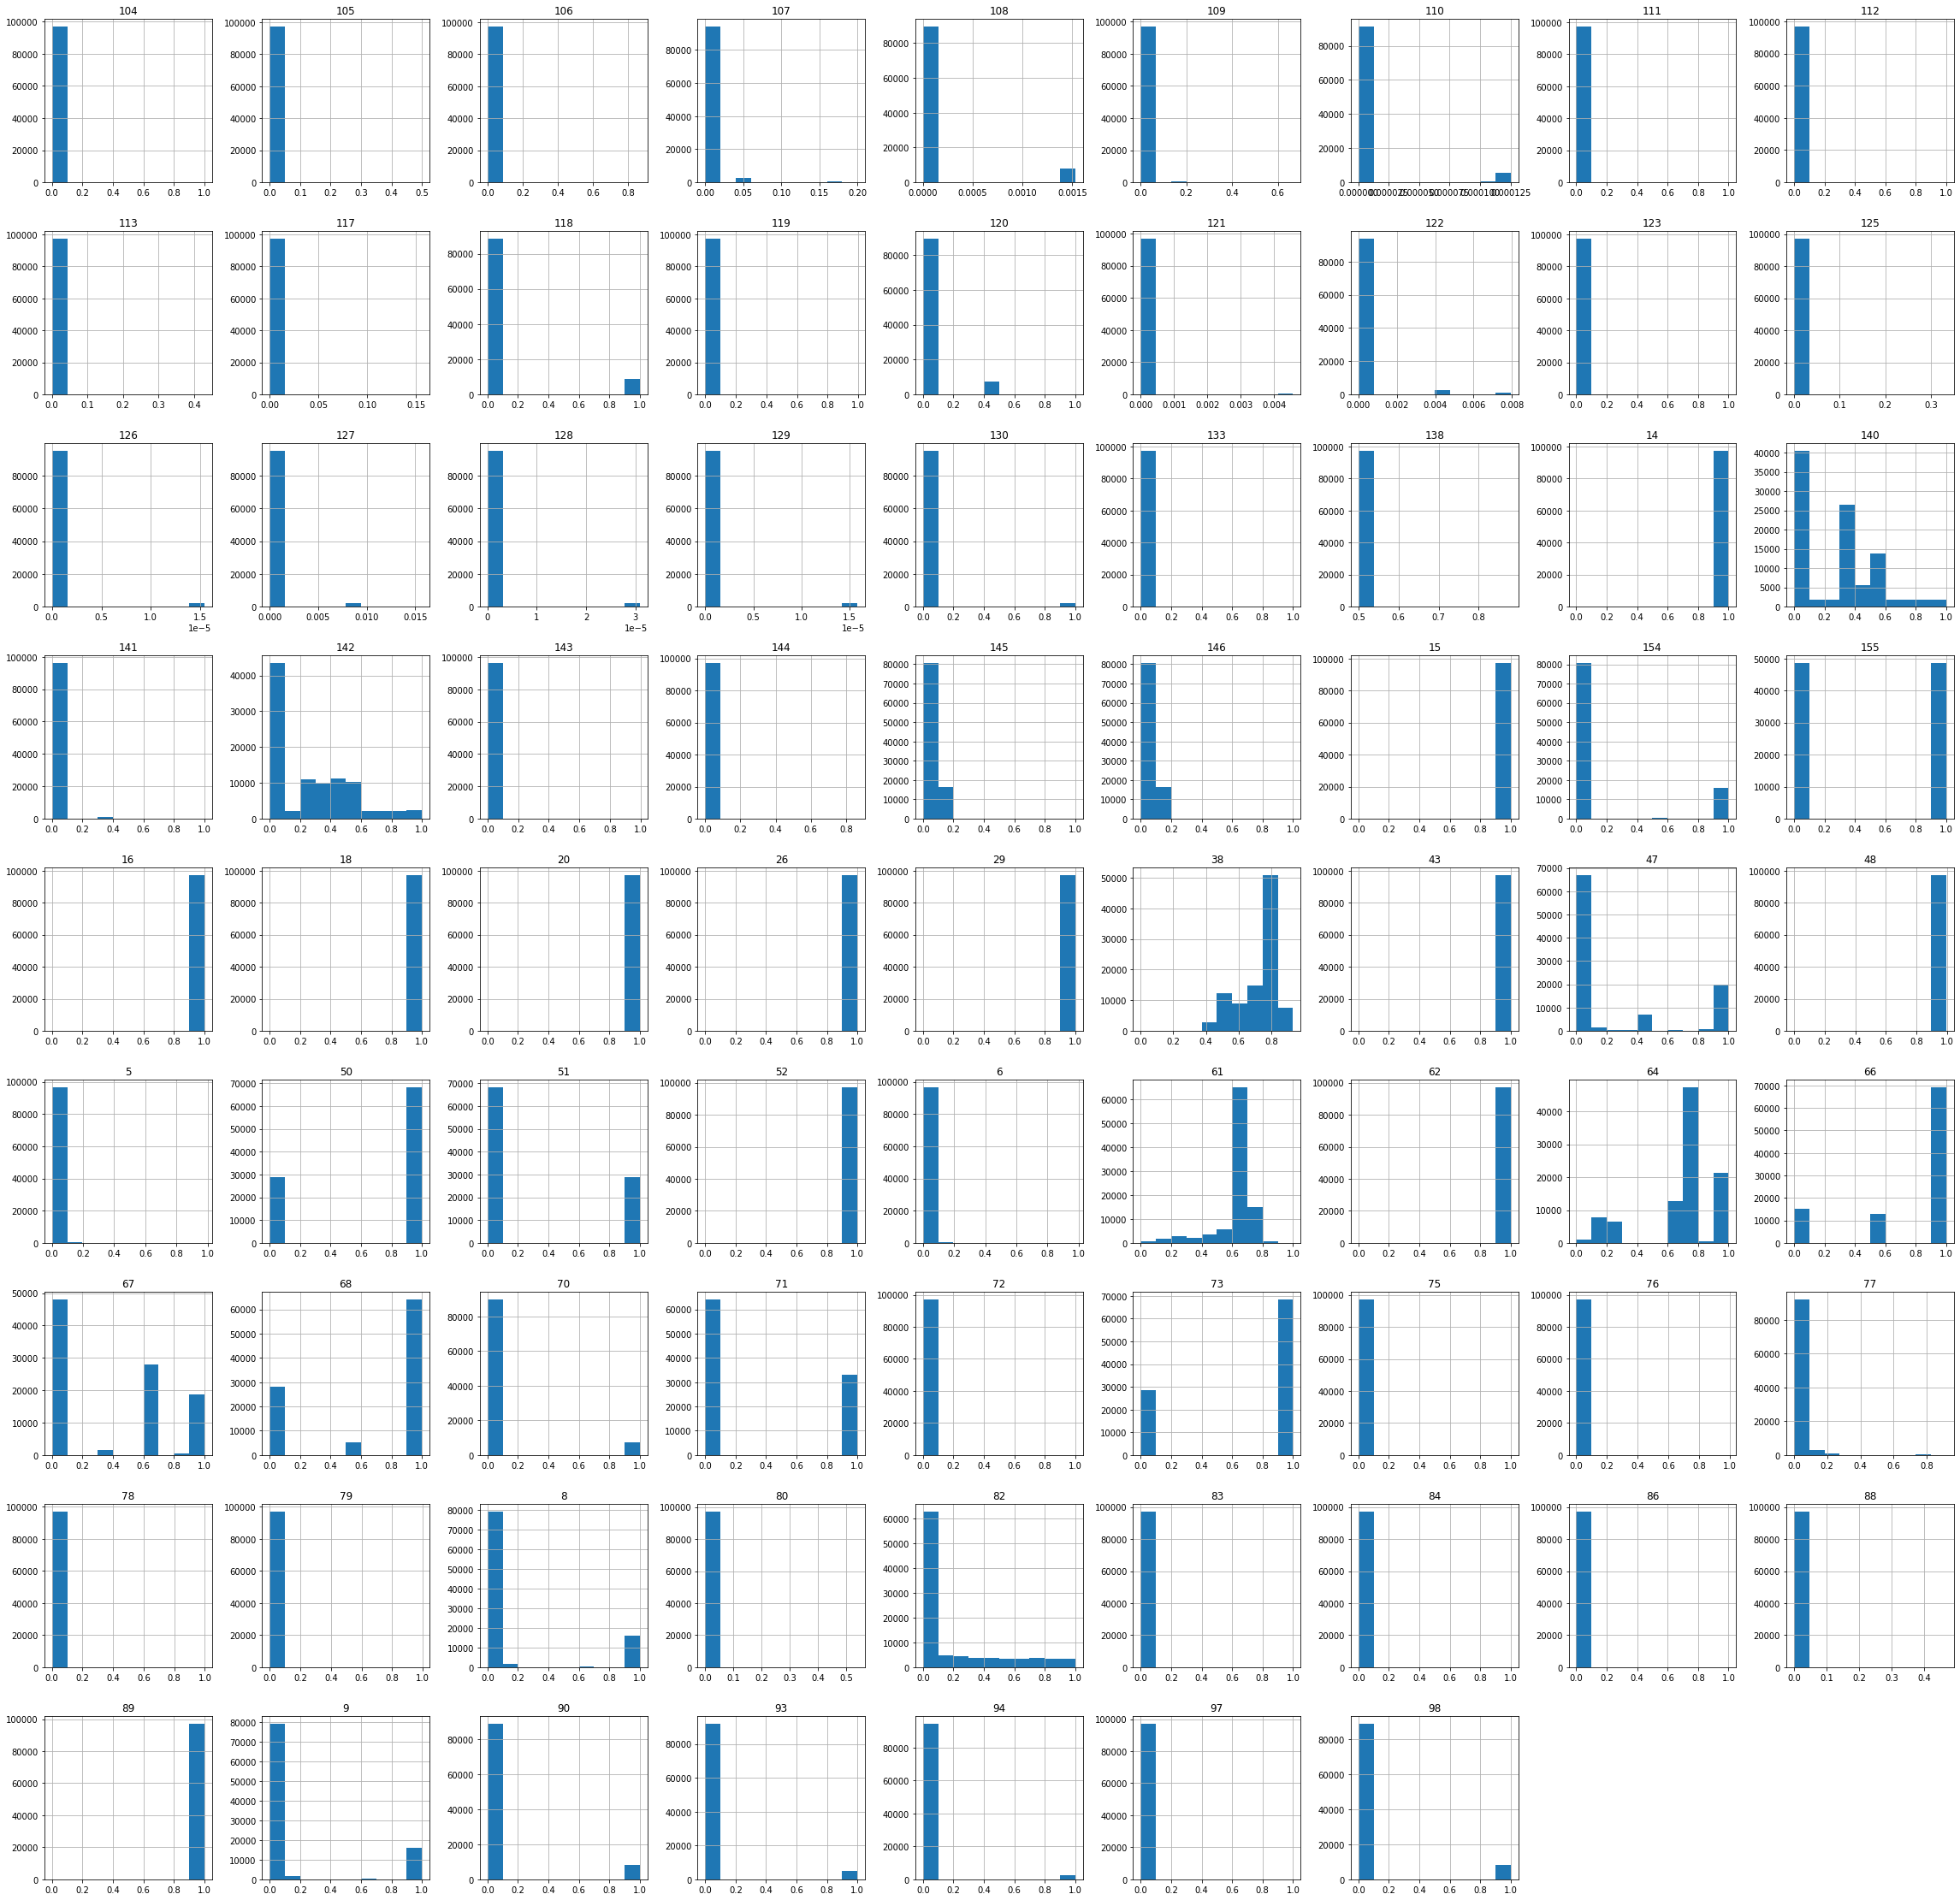

In [4]:
### Step 2 - Visualisation
# Create histograms 
df.hist(figsize=(40,40),layout=(9,9))
plt.show()


Step 3 - Standardisation
<br>
We have considered normalisation not necessary because all values are already between 0 and 1. However, we have decided to standardise the data. We will only standardise the continuous variables and we will not apply any standardisation on the binary variables. To transform only some columns and not others, we used ColumnTransformer() from sklearn.

In [5]:
### Step 3 - standardisation
columns_to_not_standardise = X.columns[X.dtypes=='int64']
columns_to_standardise = X.columns[X.dtypes=='float64']

# Standardisation will be the first step of the pipeline we create for our model
ss_step = [('scaler', StandardScaler())]
ss_pipe = Pipeline(ss_step)
ss_transformer = [('ss', ss_pipe, columns_to_standardise)]# create the list for the following variable that wraps the function to execute sequentially


ct = ColumnTransformer(transformers=ss_transformer, remainder = 'passthrough')

**SELECTING FEATURES**

High-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions. 
For this piece of work, we considered a variety of methods to select, create and reduce our features:
1. Filter methods
        1.1 ExtraTreesClassifier
        1.2 SelectKbest
        
2. Wrapper method
        2.1 RFE
        
3. Dimensionality reduction techniques
        3.1 PCA
        
4. Feature construction techniques
        4.1 Autoencoder

**EXPLORING AND SELECTING ML ALGORITHMS**
<br><br>
There are many algorithms that can be used for classification, so to select the 10 algorithms we would try we used the following strategies:
1. Tried algorithms that were used in papers trying to solve the same problem with the same dataset
2. Tried algorithms that are very popular in Kaggle competitions
3. Tried algorithms that have high probability of performing well in classification tasks according to research
4. Tried a range of algorithms



Based on the above strategy, the candidate algorithms we tried were:
1. Logistic regression (Parker et al 2019)
2. Naive Bayes (Kolias et al 2015)
3. Random Forest (Delgado et al 2014)
4. SVM with Gaussian kernel and polynomial kernel (Delgado et al 2014)
5. XGBClassifier and LightGBM(Kaggle competitions' most popular algorithm)
6. Neural Network (Aminato et al 2018)
7. RBF Classifier (Parker et al 2019)
8. KNN (distance based)
9. Decision Tree (explainability)
10. LDA (LR alternative)


We then used the above algorithms with default parameters and different combinations of features to predict the test dataset. Our prefered metric was accuracy as the dataset is balanced. 

We start by trying the algorithms with seneral configurations of PCA and Kbest(univariate selection), as they work well with the pipeline architecture. We quickly see that, for most methods, PCA does not yield better results than univariate selection.
Below you can see a trimmed down version of the combination of models and feature selection tried.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=7)


model_dict = {'lr_pca10':[('transform', ct),('pca', PCA(n_components=10)),
                          ('lr', LogisticRegression(solver='saga',random_state = 7))],
              
              'lr_pca5':[('transform', ct),('pca', PCA(n_components=5)),
                         ('lr', LogisticRegression(solver='saga',random_state = 7))],
              
              'lr_kbest10':[('transform', ct),('bestk', SelectKBest(score_func=f_classif)),
                            ('lr', LogisticRegression(solver='saga',random_state = 7))],
              
              'lr_kbest5':[('transform', ct),('bestk', SelectKBest(score_func=f_classif,k=5)),
                           ('lr', LogisticRegression(solver='saga',random_state = 7))],
              

              'xgb_pca5':[('transform', ct),('pca', PCA(n_components=5)),
                          ('xgb', XGBClassifier(random_state=7, seed=1))],
              
              'xgb_kbest10':[('transform', ct),('bestk', SelectKBest(score_func=f_classif, k=10)),
                             ('xgb', XGBClassifier(random_state=7, seed=1))],
              
              'xgb_kbest5':[('transform', ct),('bestk', SelectKBest(score_func=f_classif,k=5)),
                            ('xgb', XGBClassifier(random_state=7, seed=1))],
 
              
              'lightgbm_pca5':[('transform', ct),('pca', PCA(n_components=5)),
                               ('xgb', lgb.LGBMClassifier(random_state=7, silent=False))],
              
              'lightgbm_kbest10':[('transform', ct),
                                  ('bestk', SelectKBest(score_func=f_classif, k=10)),
                                  ('xgb',lgb.LGBMClassifier(random_state=7, silent=False))],
              
              'lightgbm_kbest5':[('transform', ct),
                                 ('bestk', SelectKBest(score_func=f_classif,k=5)),
                                 ('xgb', lgb.LGBMClassifier(random_state=7, silent=False))],
              

              'lda_pca20':[('transform', ct),('pca', PCA(n_components=20)),
                           ('lda', LinearDiscriminantAnalysis())],
              
              'lda_pca10':[('transform', ct),('pca', PCA(n_components=10)),
                           ('lda', LinearDiscriminantAnalysis())],
              
              'lda_kbest10':[('transform', ct),
                             ('bestk', SelectKBest(score_func=f_classif, k=10)),
                             ('lda', LinearDiscriminantAnalysis())],
              
              'lda_kbest5':[('transform', ct),('bestk', SelectKBest(score_func=f_classif, k=5)),
                            ('lda', LinearDiscriminantAnalysis())],
              
              'lda_kbest2':[('transform', ct),('bestk', SelectKBest(score_func=f_classif, k=2)),
                            ('lda', LinearDiscriminantAnalysis())],

              
              'gnb_pca20':[('transform', ct),('pca', PCA(n_components=20)),
                           ('gnb', GaussianNB())],
              
              'gnb_pca10':[('transform', ct),('pca', PCA(n_components=10)),
                           ('gnb', GaussianNB())],
              
              'gnb_pca5':[('transform', ct),('pca', PCA(n_components=5)),
                          ('gnb', GaussianNB())],
              
              'gnb_kbest10':[('transform', ct),('bestk',SelectKBest(score_func=f_classif,k=10)),
                             ('gnb', GaussianNB())],
              
              'gnb_kbest5':[('transform', ct),('bestk',SelectKBest(score_func=f_classif,k=5)),
                            ('gnb', GaussianNB())],
              

              'knn3_pca10':[('transform', ct),('pca', PCA(n_components=10)),
                            ('knn', KNeighborsClassifier(n_neighbors=3))],  
              
              'knn3_pca5':[('transform', ct),('pca', PCA(n_components=5)),
                           ('knn', KNeighborsClassifier(n_neighbors=3))],
              
              'knn3_kbest5':[('transform', ct),('bestk',SelectKBest(score_func=f_classif,k=5)),
                             ('knn', KNeighborsClassifier(n_neighbors=3))],
              

              'knn5_pca10':[('transform', ct),('pca', PCA(n_components=10)),
                            ('knn', KNeighborsClassifier(n_neighbors=5))],   
              
              'knn5_pca2':[('transform', ct),('pca', PCA(n_components=2)),
                           ('knn', KNeighborsClassifier(n_neighbors=5))],
              
              'knn5_kbest5':[('transform', ct),('bestk',SelectKBest(score_func=f_classif,k=5)),
                             ('knn', KNeighborsClassifier(n_neighbors=5))],
              
              'knn5_kbest2':[('transform', ct),('bestk',SelectKBest(score_func=f_classif,k=2)),
                             ('knn', KNeighborsClassifier(n_neighbors=5))],
              

              'svm_poly_kbest5':[('transform', ct),
                                 ('bestk',SelectKBest(score_func=f_classif,k=5)),
                                 ('svm', SVC(kernel='poly', random_state=7))],
              
              'svm_poly_kbest2':[('transform', ct),
                                 ('bestk',SelectKBest(score_func=f_classif,k=2)),
                                 ('svm', SVC(kernel='poly', random_state=7))],
              

              'svm_rbf_pca5':[('transform', ct),('pca',PCA(n_components=5)),
                              ('svm', SVC(kernel='rbf', random_state=7))],
              
              'svm_rbf_kbest5':[('transform', ct),
                                ('bestk',SelectKBest(score_func=f_classif,k=5)),
                                ('svm', SVC(kernel='rbf', random_state=7))],
              
              'svm_rbf_kbest2':[('transform', ct),
                                ('bestk',SelectKBest(score_func=f_classif,k=2)),
                                ('svm', SVC(kernel='rbf', random_state=7))],

              
              'dt_pca2':[('transform', ct),('pca', PCA(n_components=2)),
                         ('dt', DecisionTreeClassifier(random_state = 7))],
              
              'dt_kbest5':[('transform', ct),('bestk',SelectKBest(score_func=f_classif,k=5)),
                           ('dt', DecisionTreeClassifier(random_state = 7))],
              
              'dt_kbest2':[('transform', ct),('bestk',SelectKBest(score_func=f_classif,k=2)),
                           ('dt', DecisionTreeClassifier(random_state = 7))],
              

              'rf10_pca10':[('transform', ct),('pca', PCA(n_components=10)),
                            ('rf', RandomForestClassifier(n_estimators =10, random_state = 7))
                           ],
              'rf10_kbest10':[('transform', ct),
                              ('bestk',SelectKBest(score_func=f_classif,k=10)),
                              ('rf', RandomForestClassifier(n_estimators =10, random_state = 7))],

              
              'rf4_pca20':[('transform', ct),
                           ('pca', PCA(n_components=20)),
                           ('rf', RandomForestClassifier(n_estimators =4, random_state = 7))],
              
              'rf4_pca10':[('transform', ct),('pca', PCA(n_components=10)),
                           ('rf', RandomForestClassifier(n_estimators =4, random_state = 7))],
              
              'rf4_pca5':[('transform', ct),('pca', PCA(n_components=5)),
                          ('rf', RandomForestClassifier(n_estimators =4, random_state = 7))],
              
              'rf4_kbest5':[('transform', ct),
                            ('bestk',SelectKBest(score_func=f_classif,k=5)),
                            ('rf', RandomForestClassifier(n_estimators =4, random_state = 7))],
         }



def get_res_df(cv_results, model):
    res = [model]
    for k in cv_results.keys():
        res.append(cv_results[k].mean())

    return pd.DataFrame([res],columns = ['model']+[l for l in cv_results.keys()])



cv_df = pd.DataFrame(columns=['model','fit_time','score_time','test_accuracy','test_recall'])
res_df = pd.DataFrame(columns =['model','accuracy', 'precision', 'recall','FNR','FAR','mcc','time_to_train'])
fitted_models = {}

for name in model_dict.keys():
    model = Pipeline(model_dict[name])   

    # evaluate pipeline 
    kfold = KFold(n_splits=10, random_state=7) 
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=['accuracy', 'recall']) 
    start = time()
    fitted_models[name] = model.fit(X_train, Y_train)
    time_to_train = time() - start

    y_pred = model.predict(test_df[feature_list])
    y_true = test_df[test_df.columns[-1]]
    
    # output results
    cv_df = cv_df.append(get_res_df(cv_results, name))
    res_df = res_df.append(utils.get_metrics(name, y_true, y_pred, time_to_train))

    

Then we implement a Neural Network Classification algorithm. We tried a couple of specifications 1 or 2 hidden layers and different combinations of feature selection methods and number of features. The architecture that gave the most promissing results was the classifier with 1 hidden layer and 5 inputs selected though univariate selection(kbest).

In [8]:
tf.random.set_random_seed(41)

def NeuralNet1L(kernel_initializer='glorot_uniform', l1_neuron = 5, metrics = ['accuracy'], loss = 'binary_crossentropy', optimizer = 'adam'):
    nn_model = Sequential()  
    nn_model.add(Dense(l1_neuron, activation='relu',kernel_initializer=kernel_initializer))
    nn_model.add(Dense(1, activation='sigmoid',kernel_initializer=kernel_initializer))    

    # compile model     
    nn_model.compile(loss=loss, optimizer=optimizer, metrics=metrics) 

    return nn_model


model_dict = {
              'NN1L_kbest5':[('transform', ct),('bestk', SelectKBest(score_func=f_classif,k=5)),('NN1L', KerasClassifier(NeuralNet1L, epochs=50, batch_size=5, verbose=0))],
              'NN2L_kbest5':[('transform', ct),('bestk', SelectKBest(score_func=f_classif,k=5)),('NN2L', KerasClassifier(NeuralNet1L, epochs=50, batch_size=5, verbose=0))]  

}


# reset X and Y
X = df.iloc[:, :-1] 
Y = df.iloc[:, -1]


for name in model_dict.keys():    
    model = Pipeline(model_dict[name]) 
    start = time()
    model.fit(X,Y)
    time_to_train = time() - start
    y_pred = model.predict(test_df[feature_list])
    y_true = test_df[test_df.columns[-1]]
    res_df = res_df.append(utils.get_metrics(name, y_true, y_pred, time_to_train))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Following the paper from Parker et al. 2018, we tried using an RBF Network as a classifier, as out of all the algorithms examined in the Parker et al paper, the RBF Network model when combined with sparse autoencoder features, performed the best. In our analysis we fed our RBF Network with features selected through univariate feature selection. Our RBF Network model  has three layers: input, hidden layer and output layer. Each neuron in the hidden layer consists of a radial basis function and in the output layer the activation function is sigmoid. 

To decide the RBF unit centers, we used K-means clustering.


$f\left(x\right)=\sum_{j=1}^{m}{w_jh_j\left(x\right)}$


$h_{\left(x\right)}=exp\left(-\frac{\left(x-c\right)^2}{r^2}\right)$  where r is the distance between the cluster center and its K nearest neighbors, c is the center of the neuron of the hidden layer and w is the weights

Following in the footsteps of the Parker et al. paper, we also used logistic regression as a classifier. The logistic regression model is easy to interpret and simple to implement so we tried using a) features selected through univariate feature selection and b) a more complicated feature selection method, where we used a bagged decision tree method called ExtraTressClassifier to get the most important features from the data and then combine them with the features generated by a stacked sparse autoencoder and used a wrapper method(RFE) to select the most relevant features using logistic regression.

In [10]:
from rbf_keras.rbflayer import RBFLayer, InitCentersRandom
from rbf_keras.kmeans_initializer import InitCentersKMeans
tf.random.set_random_seed(41)


def rbfn():
    model = Sequential()
    rbflayer = RBFLayer(4,
                        initializer=InitCentersKMeans(X),
                        betas=2.0,
                        input_shape=(X.shape[1],))
    model.add(rbflayer)
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=RMSprop())

    #model.fit(X, y,batch_size=50,epochs=2,verbose=1)
    return model
    
model_dict = {
              'rbfn':[('transform', ct),('bestk', SelectKBest(score_func=f_classif,k=5)),('rbfn', KerasClassifier(rbfn))]  }

# reset X and Y
X = df.iloc[:, :-1] 
Y = df.iloc[:, -1]

# scale
scaler = StandardScaler()
sX_train = scaler.fit_transform(X)
sX_test = scaler.transform(test_df[feature_list])

# best 5 features
fx = SelectKBest(score_func=f_classif, k=5) 
X = fx.fit_transform(sX_train, Y)
bk_train = fx.transform(sX_test)

# fit model
start = time()
model = rbfn() 
model.fit(X, y=Y, batch_size=50, epochs=20, verbose = 0)
time_to_train = time() - start

# predict
y_pred = model.predict_proba(bk_train)
y_pred2 = np.arange(0,len(y_pred))
for y in range(len(y_pred)):
    if y_pred[y]>0.6:
        y_pred2[y] = 1
    else:
        y_pred2[y] = 0
y_true = test_df.iloc[:,-1]

# score
accuracy_score(y_true, y_pred2)

res_df = res_df.append(utils.get_metrics('rfb_kbest5', y_true, y_pred2, time_to_train))


Finally we try ExtraTressClassifier to get the most important features from the data and then combine them with the features generated by a stacked sparse autoencoder and used a wrapper method(RFE) to select the most relevant features using logistic regression. We tried the autoencoder with several layers and legularization(stacked and sparse AE) as the vanilla AE overfit the data. This model achieves 93.96% accuracy, using as predictors 1 of the original features (3, 13, 27) and 2 encoded features ('ae0').

In [15]:
# reset X and Y
X = df.iloc[:, :-1] 
Y = df.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=7)


# scale
scaler = StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_train_test = scaler.fit_transform(X_test)
sX_test = scaler.transform(test_df[feature_list])

# autoencoder
num_features = sX_train.shape[1]
input_dim = Input(shape = (num_features,))
encoding_dim = 50

encoded = Dense(95, activation = 'sigmoid',activity_regularizer=l1(0.001), kernel_initializer='normal')(input_dim)
encoded = Dense(encoding_dim, activation = 'sigmoid',activity_regularizer=l1(0.001), kernel_initializer='normal')(encoded)
decoded = Dense(95, activation = 'sigmoid')(encoded)
decoded = Dense(num_features, activation = 'sigmoid')(decoded)
autoencoder = Model(input_dim, decoded)

autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# fit the model
autoencoder.fit(sX_train, sX_train, epochs = 50, batch_size = 50, verbose = 0)

encoder = Model(input_dim, encoded)
X_train_ae = encoder.predict(sX_train)
X_test_ae  = encoder.predict(sX_test)


# ExtraTree Gini original features
fx = ExtraTreesClassifier(criterion='gini', random_state=123, n_estimators=20)
fx.fit(sX_train, Y_train)
importances_e = fx.feature_importances_

# keep features that feature importance is above a treshold of 0.01
e_col_idx = np.where(importances_e > 0.01)[0][:20]
bk_train = pd.DataFrame(sX_train).iloc[:,e_col_idx]
bk_test = pd.DataFrame(sX_test).iloc[:,e_col_idx]


# add autoencoder features to the selected original features(bk)
new_Xtrain = pd.concat([bk_train,pd.DataFrame(X_train_ae,columns=['ae{}'.format(i) for i in range(X_train_ae.shape[1])])],axis=1)
new_Xtest = pd.concat([bk_test,pd.DataFrame(X_test_ae,columns=['ae{}'.format(i) for i in range(X_test_ae.shape[1])])],axis=1)


# fit model
model = LogisticRegression(solver = 'saga', penalty = 'l2', C=0.1, max_iter = 1000)
rfe = RFE(model, 4)

start = time()
model = rfe.fit(new_Xtrain, Y_train)
time_to_train = time() - start

# predict
y_pred = model.predict(new_Xtest)
y_true = test_df[df.columns[-1]]

# score
accuracy_score(y_true, y_pred)

# Accuracy: 0.939663329847104
# features [3, 13, 27, 'ae0']

0.9362767070073211

In [ ]:
display(res_df.sort_values(by=['accuracy'], ascending=False).head(9))

**Model Training**

To get the most out of well-performing algorithms on our data, we used algorithm tuning. Based on the accuracy stats, interpretability and time to train, we selected the algorithms that would move to the model tuning stage. These models are logistic regression, RBFNetwork and XGBoost. 

In [74]:
# Logistic regression tunning
grid_params = [{'bestk__k':np.arange(5, 10, 1),
                   'lr__penalty': ['l2','l1'],
                    'lr__C': [100, 10.0, 1, 0.1],
                    'lr__solver': ['saga']}] 

model = Pipeline([('transform', ct),
                        ('bestk', SelectKBest(score_func=f_classif,k=5)),
                        ('lr', LogisticRegression(random_state=41))])


tuned_model = GridSearchCV(estimator=model,
                        param_grid=grid_params,
                        scoring='accuracy',
                        cv=5,
                        return_train_score=True)

search = tuned_model.fit(X_train, Y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)

## inbluilt print fucntion
print(search.best_params_)

Best parameter (CV score=0.963):
{'bestk__k': 9, 'lr__C': 100, 'lr__penalty': 'l1', 'lr__solver': 'saga'}


In [73]:
#XGBoost tuning

model = Pipeline([('transform', ct),
                        ('bestk', SelectKBest(score_func=f_classif,k=5)),
                        ('xgb', XGBClassifier(random_state=41))])
  
param_grid = {'bestk__k':np.arange(3, 7, 1),
              'xgb__max_depth': np.arange(5, 10, 1),
             'xgb__min_child_weight' : [ 1, 3, 5, 7 ]} 

tuned_model = RandomizedSearchCV(estimator=model,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        cv=4)
tuned_model.fit(X_train, Y_train)
print(tuned_model.best_params_)

{'xgb__min_child_weight': 1, 'xgb__max_depth': 5, 'bestk__k': 6}


In [ ]:
from keras.layers import Dense, Dropout
from keras.callbacks import LearningRateScheduler


# wrap the model using the function you created
nn2l = KerasRegressor(build_fn=utils.NeuralNet2L,verbose=5)



param_grid = {
    'nn2l__optimizer':['adam'],
    'nn2l__epochs':[100],
    'nn2l__batch_size':[32],    
    'nn2l__l1_neuron':[15, 10],    
    'nn2l__l2_neuron':[5, 3],
    'nn2l__dropout': [0.1, 0.2]
}

pipeline = Pipeline([('transform', ct),('bestk', SelectKBest(score_func=f_classif,k=5)),('nn2l',nn2l)])

grid = GridSearchCV(pipeline, cv=3, param_grid=param_grid, n_jobs=2)
grid.fit(X_train,  np.array(Y_train))

# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))


**EVALUATING MODEL AND ANALYSING THE RESULTS**

To judge how good each algorithm was, we first and foremost looked at accuracy. Accuracy is the number of predictions we got right over the total number of predictions.

$Accuracy=\frac{TP+TN}{TP\ +\ TN\ +FP\ +FN}$

We thought that accuracy was a valid metric since the classes were balanced and it was equally important to get the intrusion attempts right as it was to get the normal traffic right, as if it was incorrectly classified and an action to stop it was taken, it would affect the user experience making the algorithm unusable in real life scenarios. A second consideration was the interpretability of the algorithm, and the time it took to get trained.


In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=7)


model_dict = {
              'lr_kbest15':[('transform', ct),('bestk', SelectKBest(score_func=f_classif,k=15)),
                           ('lr', LogisticRegression(solver='saga',random_state = 7,C=100))],
      
              'xgb_kbest5':[('transform', ct),('bestk', SelectKBest(score_func=f_classif,k=5)),
                            ('xgb', XGBClassifier(random_state=7, xgb__min_child_weight= 1, max_depth=6, seed=1))],
    
              'NN2L_kbest5':[('transform', ct),('bestk', SelectKBest(score_func=f_classif,k=5)),
                             ('NN2L', KerasClassifier(NeuralNet1L, epochs=50, batch_size=5, verbose=0))]           
         }


def get_res_df(cv_results, model):
    res = [model]
    for k in cv_results.keys():
        res.append(cv_results[k].mean())

    return pd.DataFrame([res],columns = ['model']+[l for l in cv_results.keys()])



cv_df = pd.DataFrame(columns=['model','fit_time','score_time','test_accuracy','test_recall'])
res_df = pd.DataFrame(columns =['model','accuracy', 'precision', 'recall','FNR','FAR','mcc','time_to_train'])
fitted_models = {}

for name in model_dict.keys():
    model = Pipeline(model_dict[name])   

    # evaluate pipeline 
    kfold = KFold(n_splits=10, random_state=7) 
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=['accuracy', 'recall']) 
    start = time()
    fitted_models[name] = model.fit(X_train, Y_train)
    time_to_train = time() - start

    y_pred = model.predict(test_df[feature_list])
    y_true = test_df[test_df.columns[-1]]
    
    # output results
    cv_df = cv_df.append(get_res_df(cv_results, name))
    res_df = res_df.append(utils.get_metrics(name, y_true, y_pred, time_to_train))

    